In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.neighbors import NearestNeighbors, KernelDensity
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from scipy.stats import pearsonr, spearmanr
import numpy as np

np.set_printoptions(precision=2, suppress=True)

In [17]:
def kde_density(data, bandwidth=0.2):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data)
    log_dens = kde.score_samples(data)
    return np.exp(log_dens)

def knn_density(data, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nbrs.kneighbors(data)
    return 1.0 / (distances[:, -1] + 1e-8)

def knn_avg_density(data, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nbrs.kneighbors(data)
    avg_dists = distances.mean(axis=1)
    return 1.0 / (avg_dists + 1e-8)

def christoffel_density(data, degree=3):
    N = len(data)
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    V = poly.fit_transform(data)
    s = V.shape[1]

    res = np.zeros((s, s))
    for i in range(N):
        Vi = V[i].reshape(-1, 1)
        res += Vi @ Vi.T

    M_d = (1.0 / N) * res
    M_d_inv = np.linalg.pinv(M_d)
    Q = np.sum(V * (np.dot(V, M_d_inv)), axis=1)
    Lambda = 1.0 / Q
    return s * Lambda

def analyze_dataset(data, name, k=5, bandwidth=0.2, degree=3):
    density_kde = kde_density(data, bandwidth=bandwidth)
    density_knn = knn_density(data, k=k)
    density_knn_avg = knn_avg_density(data, k=k)
    density_christ = christoffel_density(data, degree=degree)

    scaler = MinMaxScaler()
    density_kde = scaler.fit_transform(density_kde.reshape(-1, 1)).ravel()
    density_knn = scaler.fit_transform(density_knn.reshape(-1, 1)).ravel()
    density_knn_avg = scaler.fit_transform(density_knn_avg.reshape(-1, 1)).ravel()
    density_christ = scaler.fit_transform(density_christ.reshape(-1, 1)).ravel()

    correlations = {
        "Pearson KDE vs KNN": pearsonr(density_kde, density_knn)[0],
        "Pearson KDE vs KNN-AVG": pearsonr(density_kde, density_knn_avg)[0],
        "Pearson KDE vs Christoffel": pearsonr(density_kde, density_christ)[0],
        "Pearson KNN vs KNN-AVG": pearsonr(density_knn, density_knn_avg)[0],
        "Pearson KNN vs Christoffel": pearsonr(density_knn, density_christ)[0],
        "Pearson KNN-AVG vs Christoffel": pearsonr(density_knn_avg, density_christ)[0],
        "Spearman KDE vs KNN": spearmanr(density_kde, density_knn)[0],
        "Spearman KDE vs KNN-AVG": spearmanr(density_kde, density_knn_avg)[0],
        "Spearman KDE vs Christoffel": spearmanr(density_kde, density_christ)[0],
        "Spearman KNN vs KNN-AVG": spearmanr(density_knn, density_knn_avg)[0],
        "Spearman KNN vs Christoffel": spearmanr(density_knn, density_christ)[0],
        "Spearman KNN-AVG vs Christoffel": spearmanr(density_knn_avg, density_christ)[0],
    }

    print(f"Датасет: {name}")
    for key, value in correlations.items():
        print(f"{key:40s}: {value:.3f}")
    print("-" * 60)

    return correlations

datasets = {
    "blobs": make_blobs(n_samples=200, centers=3, cluster_std=1.0, random_state=0)[0],
    "moons": make_moons(n_samples=200, noise=0.1, random_state=0)[0],
    "circles": make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=0)[0]
}

scaler_global = MinMaxScaler()
results = {}
for name, data in datasets.items():
    data_scaled = scaler_global.fit_transform(data)
    results[name] = analyze_dataset(data_scaled, name, k=9, bandwidth=0.1, degree=2)

Датасет: blobs
Pearson KDE vs KNN                      : 0.891
Pearson KDE vs KNN-AVG                  : 0.846
Pearson KDE vs Christoffel              : 0.918
Pearson KNN vs KNN-AVG                  : 0.925
Pearson KNN vs Christoffel              : 0.739
Pearson KNN-AVG vs Christoffel          : 0.703
Spearman KDE vs KNN                     : 0.866
Spearman KDE vs KNN-AVG                 : 0.813
Spearman KDE vs Christoffel             : 0.899
Spearman KNN vs KNN-AVG                 : 0.927
Spearman KNN vs Christoffel             : 0.682
Spearman KNN-AVG vs Christoffel         : 0.660
------------------------------------------------------------
Датасет: moons
Pearson KDE vs KNN                      : 0.621
Pearson KDE vs KNN-AVG                  : 0.578
Pearson KDE vs Christoffel              : 0.509
Pearson KNN vs KNN-AVG                  : 0.888
Pearson KNN vs Christoffel              : 0.320
Pearson KNN-AVG vs Christoffel          : 0.293
Spearman KDE vs KNN                     : 0.6

In [23]:
X_circles = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=0)[0]
density_knn = knn_density(X_circles)
density_kde = kde_density(X_circles, bandwidth=0.1)
density_christoffel = christoffel_density(X_circles, degree=3)

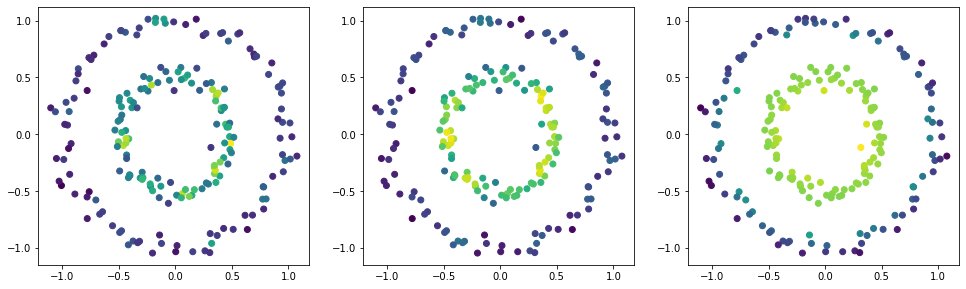

In [27]:
fig, ax = plt.subplots(ncols=3, figsize=(16.5, 4.75))
ax[0].scatter(X_circles[:,0], X_circles[:,1], c=density_knn)
ax[1].scatter(X_circles[:,0], X_circles[:,1], c=density_kde)
ax[2].scatter(X_circles[:,0], X_circles[:,1], c=density_christoffel)
plt.show()